# CFN Exploration

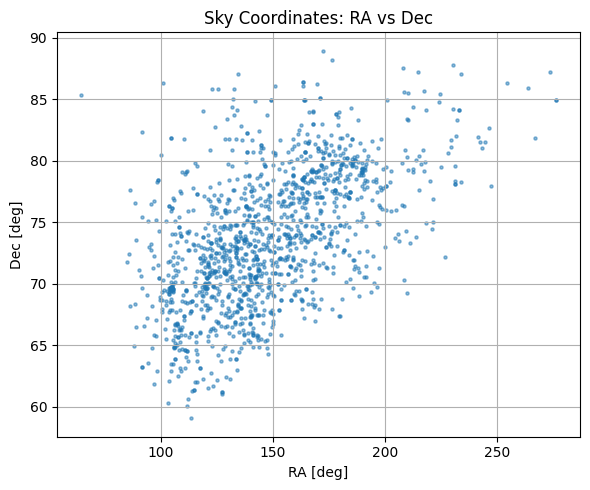

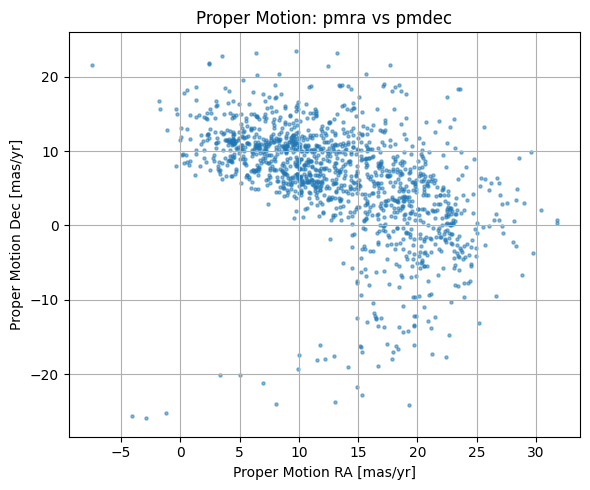

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df_cfn = pd.read_csv("CFN_AllRVs.csv")
ra = df_cfn["RA"].values
dec = df_cfn["Dec"].values
pmra = df_cfn["pmra"].values
pmdec = df_cfn["pmdec"].values
d = df_cfn["d"].values
rv = df_cfn["RV"].values
plx = df_cfn["parallax"].values

# Part 1a: RA vs Dec
ra_shifted = (ra + 180) % 360
plt.figure(figsize=(6, 5))
plt.scatter(ra_shifted, dec, s=5, alpha=0.5)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Sky Coordinates: RA vs Dec")
plt.grid()
plt.tight_layout()
plt.savefig("fig_ra_dec.pdf")  
plt.show()

# Part 1b: Proper Motion (pmra vs pmdec)
plt.figure(figsize=(6, 5))
plt.scatter(pmra, pmdec, s=5, alpha=0.5)
plt.xlabel("Proper Motion RA [mas/yr]")
plt.ylabel("Proper Motion Dec [mas/yr]")
plt.title("Proper Motion: pmra vs pmdec")
plt.grid()
plt.tight_layout()
plt.savefig("fig_pmra_pmdec.pdf")  
plt.show()

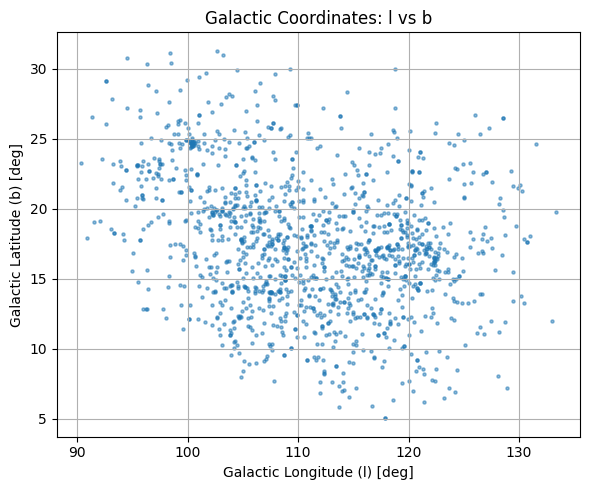

In [2]:
# Part 2

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from pyutils.gal_xyz import gal_xyz

def gal(r, d):  #input RA/Dec sky coords, output l/b galactic sky coords
    d = SkyCoord(ra=r*u.degree, dec=d*u.degree, frame='icrs')
    gd = d.transform_to('galactic')
    agl,agb = gd.l, gd.b

    return agl.value, agb.value

l_vals, b_vals = gal(ra, dec)

plt.figure(figsize=(6, 5))
plt.scatter(l_vals, b_vals, s=5, alpha=0.5)
plt.xlabel("Galactic Longitude (l) [deg]")
plt.ylabel("Galactic Latitude (b) [deg]")
plt.title("Galactic Coordinates: l vs b")
plt.grid()
plt.tight_layout()
plt.savefig("fig_galactic_lb.pdf") 
plt.show()

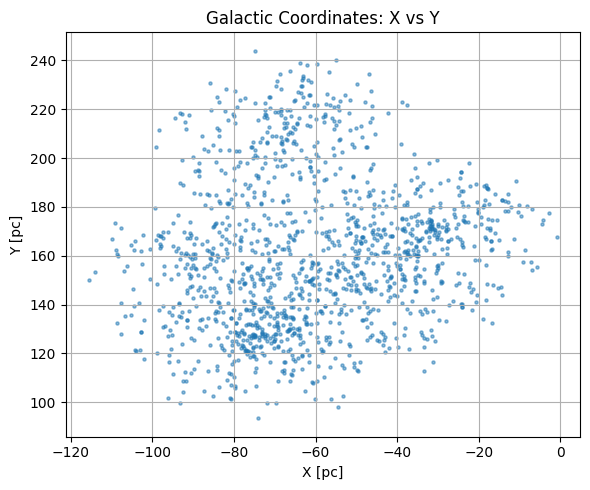

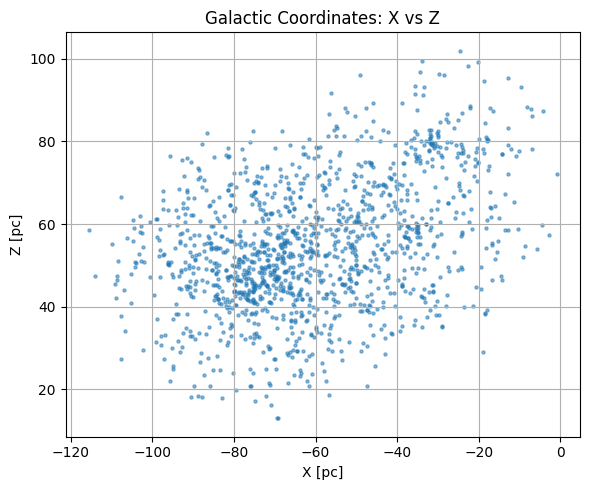

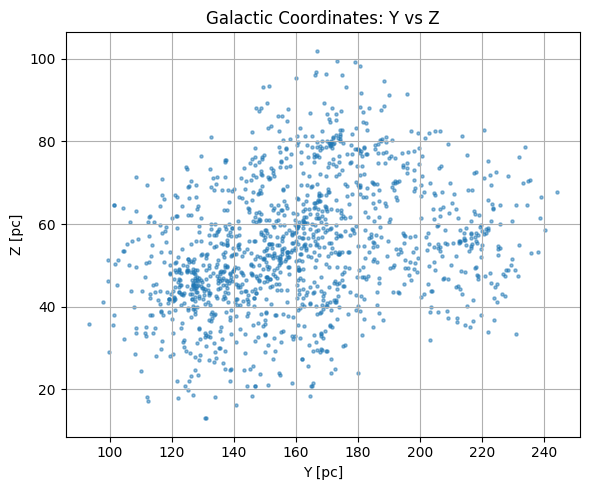

In [3]:
# Part 3

x,y,z = gal_xyz(ra,dec,d,radec=True,plx=False,reverse=False)

#X vs Y
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.5)
plt.xlabel("X [pc]")
plt.ylabel("Y [pc]")
plt.title("Galactic Coordinates: X vs Y")
plt.grid()
plt.tight_layout()
plt.savefig("fig_galactic_xy.pdf") 
plt.show()

# X vs Z
plt.figure(figsize=(6, 5))
plt.scatter(x, z, s=5, alpha=0.5)
plt.xlabel("X [pc]")
plt.ylabel("Z [pc]")
plt.title("Galactic Coordinates: X vs Z")
plt.grid()
plt.tight_layout()
plt.savefig("fig_galactic_xz.pdf") 
plt.show()

# Y vs Z
plt.figure(figsize=(6, 5))
plt.scatter(y, z, s=5, alpha=0.5)
plt.xlabel("Y [pc]")
plt.ylabel("Z [pc]")
plt.title("Galactic Coordinates: Y vs Z")
plt.grid()
plt.tight_layout()
plt.savefig("fig_galactic_yz.pdf") 
plt.show()

In [4]:
# Part 4
pctokm = 3.08567758128e13
ytos = 3.1556952e7

def pmgal(ra, dec, pmra, pmdec): #input RA, Dec and proper motion in RA, Dec, return proper motion l,b
    ipmt = coord.SkyCoord(ra=ra*u.degree, dec=dec*u.degree, pm_ra_cosdec=pmra*u.mas/u.yr, 
                          pm_dec=pmdec*u.mas/u.yr, frame='icrs')
    pmg = ipmt.transform_to(coord.Galactic)
    pml, pmb = pmg.pm_l_cosb, pmg.pm_b
    return pml, pmb


def Vt(pml, pmb, d):  #insert proper motion in l, b and distance, return transverse velocities in l, b
    d = d * u.pc   #distance in pc
    vtl = d * pml.value/206264807. * pctokm * u.km**-1
    vtb = d*pmb.value/206264807. * pctokm * u.km**-1
    return (vtl/ytos).value, (vtb/ytos).value
  
pml, pmb = pmgal(ra, dec, pmra, pmdec) 

vtl, vtb = Vt(pml, pmb, d)

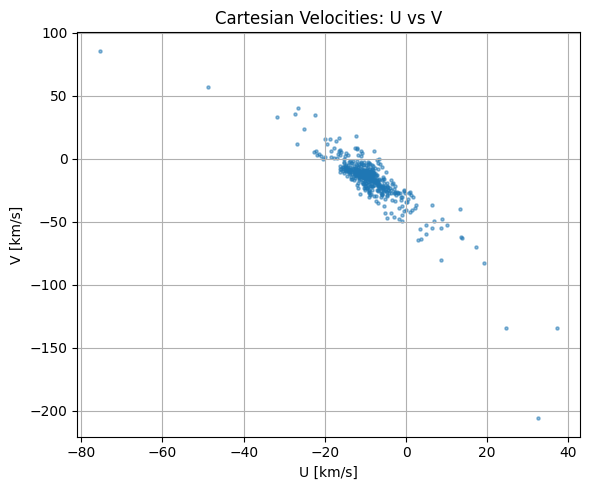

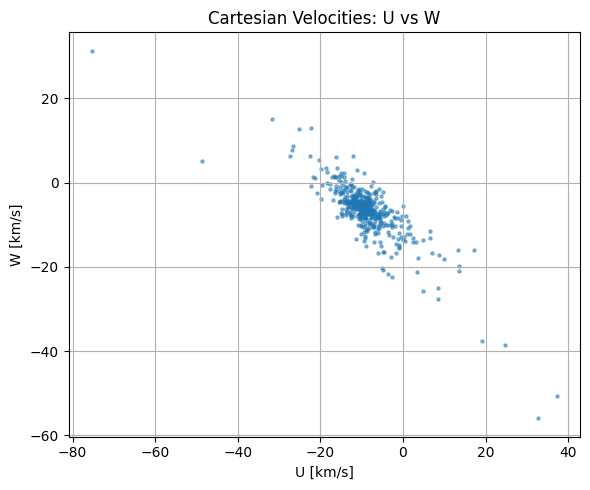

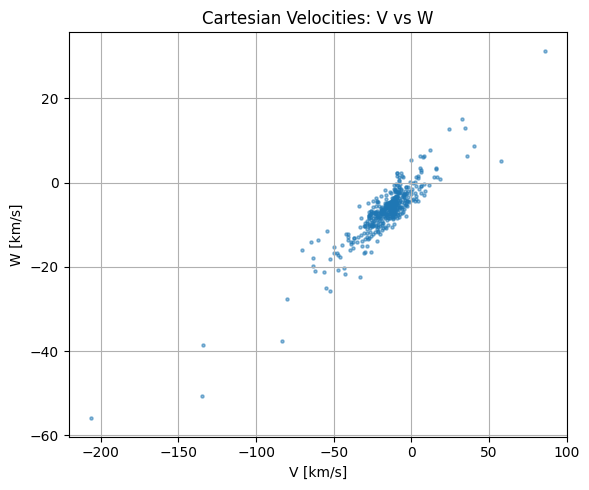

Average value of U: -9.038 km/s
Average value of V: -15.93 km/s
Average value of W: -6.481 km/s


In [5]:
# Part 5
from pyutils.ACRastro.gal_uvw import gal_uvw
u_vel, v_vel, w_vel = gal_uvw(distance=d, lsr=None, ra=ra, dec=dec, pmra=pmra, pmdec=pmdec, vrad=rv, plx=None)

# U vs V
plt.figure(figsize=(6, 5))
plt.scatter(u_vel, v_vel, s=5, alpha=0.5)
plt.xlabel("U [km/s]")
plt.ylabel("V [km/s]")
plt.title("Cartesian Velocities: U vs V")
plt.grid()
plt.tight_layout()
plt.savefig("fig_uv.pdf") 
plt.show()

# U vs W
plt.figure(figsize=(6, 5))
plt.scatter(u_vel, w_vel, s=5, alpha=0.5)
plt.xlabel("U [km/s]")
plt.ylabel("W [km/s]")
plt.title("Cartesian Velocities: U vs W")
plt.grid()
plt.tight_layout()
plt.savefig("fig_uw.pdf") 
plt.show()

# V vs W
plt.figure(figsize=(6, 5))
plt.scatter(v_vel, w_vel, s=5, alpha=0.5)
plt.xlabel("V [km/s]")
plt.ylabel("W [km/s]")
plt.title("Cartesian Velocities: V vs W")
plt.grid()
plt.tight_layout()
plt.savefig("fig_vw.pdf") 
plt.show()

# Average Values
avg_u = np.round(np.nanmean(u_vel), 3)
print(f"Average value of U: {avg_u} km/s")

avg_v = np.round(np.nanmean(v_vel), 3)
print(f"Average value of V: {avg_v} km/s")

avg_w = np.round(np.nanmean(w_vel), 3)
print(f"Average value of W: {avg_w} km/s")

In [6]:
# Part 6
def propmot(ra, dec, dist, U, V, W): #input RA, Dec, Distance, and UVW cartesian velocity, return RV and proper motion in RA, Dec
    # Ensure inputs are numpy arrays
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    dist = np.asarray(dist)
    U = np.asarray(U)
    V = np.asarray(V)
    W = np.asarray(W)
 
    # Transformation matrix TM
    TM = np.array([[-0.06699, -0.87276, -0.48354],
                   [0.49273, -0.45035, 0.74458],
                   [-0.86760, -0.18837, 0.46020]])

    # Create the output array
    num_points = ra.size
    sol = np.zeros((3, num_points))

    # Loop over each data point
    for i in range(num_points):
        # Trigonometric terms
        cosd = np.cos(np.deg2rad(dec[i]))
        sind = np.sin(np.deg2rad(dec[i]))
        cosa = np.cos(np.deg2rad(ra[i]))
        sina = np.sin(np.deg2rad(ra[i]))

        # Transformation matrix AM for each data point
        AM = np.array([[cosa * cosd, -sina, -cosa * sind],
                       [sina * cosd,  cosa, -sina * sind],
                       [sind,         0,     cosd]])

        # Matrix multiplication
        BM = np.matmul(TM, AM).T
 
        # Solve for radial velocity and proper motions
        sol[:, i] = np.matmul(BM, np.array([U[i], V[i], W[i]]))

    # Convert proper motions to mas/yr
    plx = 1e3 / dist
    sol[1, :] = sol[1, :] * plx / 4.74047
    sol[2, :] = sol[2, :] * plx / 4.74047
 
    return sol

u_arr = np.full_like(ra, avg_u)
v_arr = np.full_like(ra, avg_v)
w_arr = np.full_like(ra, avg_w)

vrad, propra, propdec = propmot(ra, dec, d, u_arr, v_arr, w_arr)

pml_proj, pmb_proj = pmgal(ra, dec, propra, propdec) 

vtl_proj, vtb_proj = Vt(pml_proj, pmb_proj, d)

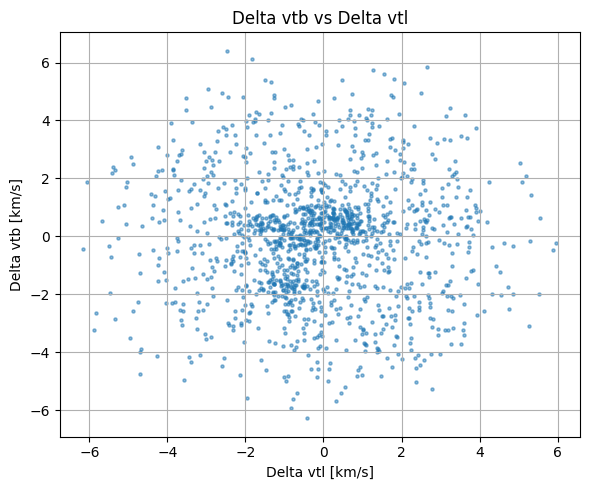

In [7]:
# Part 7

delta_vtl = vtl - vtl_proj
delta_vtb = vtb - vtb_proj

plt.figure(figsize=(6, 5))
plt.scatter(delta_vtl, delta_vtb, s=5, alpha=0.5)
plt.xlabel("Delta vtl [km/s]")
plt.ylabel("Delta vtb [km/s]")
plt.title("Delta vtb vs Delta vtl")
plt.grid()
plt.tight_layout()
plt.savefig("fig_anom.pdf") 
plt.show()

# Part 8: SCYA-89 Exploration 

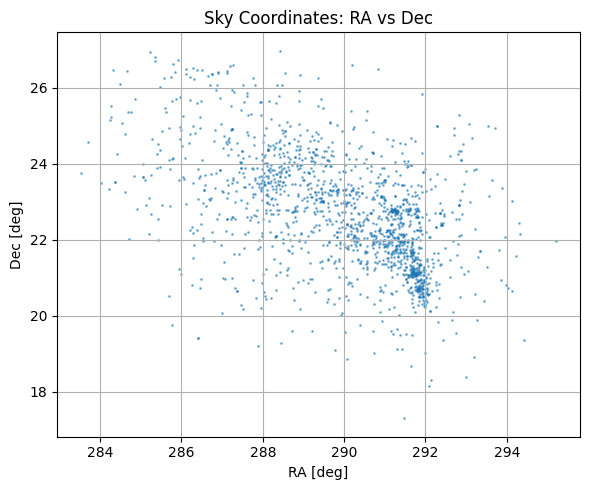

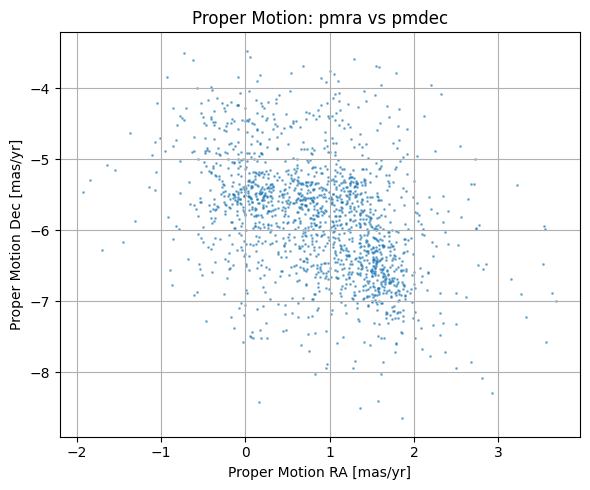

In [8]:
# Part 1

df_scya89 = pd.read_csv("SCYA89_AllRVs.csv", low_memory=False)

#Psp
Pi = 50 / 11200  
Pspatial = np.minimum(df_scya89["Pmem"].values, 0.95) # Cap Pspatial at 0.95 
Pyoung = df_scya89["Pyoung"].values  

Cy = Pspatial / Pi
Co = (1 - Pspatial) / (1 - Pi)

Psp = (Cy * Pyoung) / (Cy * Pyoung + Co * (1 - Pyoung))

df_scya89["Psp"] = Psp

filtered = (
    (df_scya89["Pmem"] > 0.3) &
    (df_scya89["Psp"] > 0.2) &
    (df_scya89["astrometric flag"] != 0) &
    (df_scya89["photometric flag"] != 0) 
)

df_pmem_scya89 = df_scya89[filtered].copy()


ra_89 = df_pmem_scya89["RA"].values
dec_89 = df_pmem_scya89["Dec"].values
pmra_89 = df_pmem_scya89["pmra"].values
pmdec_89 = df_pmem_scya89["pmdec"].values
d_89 = df_pmem_scya89["d"].values
rv_89 = df_pmem_scya89["RV"].values
plx_89 = df_pmem_scya89["parallax"].values

# RA vs Dec
plt.figure(figsize=(6, 5))
plt.scatter(ra_89, dec_89, s=1, alpha=0.5)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Sky Coordinates: RA vs Dec")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_ra_dec.pdf") 
plt.show()

# pmra vs pmdec
plt.figure(figsize=(6, 5))
plt.scatter(pmra_89, pmdec_89, s=1, alpha=0.5)

plt.xlabel("Proper Motion RA [mas/yr]")
plt.ylabel("Proper Motion Dec [mas/yr]")
plt.title("Proper Motion: pmra vs pmdec")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_pmra_pmdec.pdf") 
plt.show()

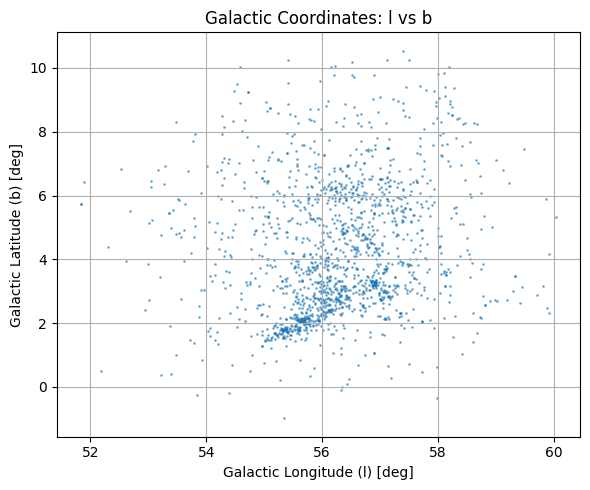

In [9]:
# Part 2

l_vals_89, b_vals_89 = gal(ra_89, dec_89)

plt.figure(figsize=(6, 5))
plt.scatter(l_vals_89, b_vals_89, s=1, alpha=0.5)
plt.xlabel("Galactic Longitude (l) [deg]")
plt.ylabel("Galactic Latitude (b) [deg]")
plt.title("Galactic Coordinates: l vs b")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_lb.pdf") 
plt.show()

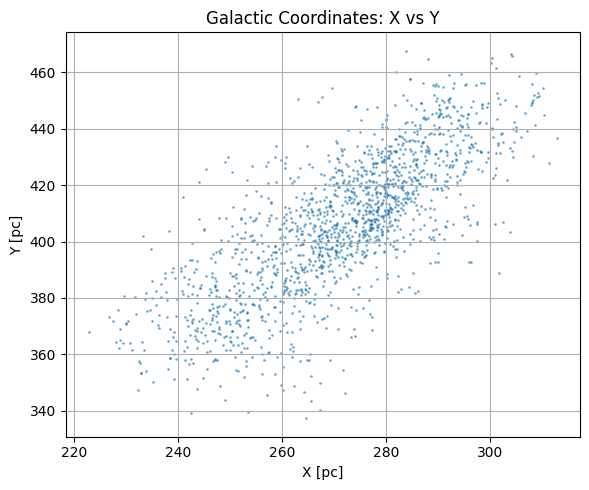

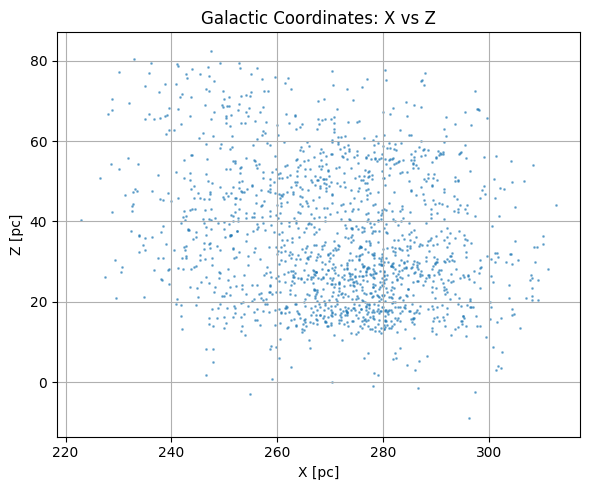

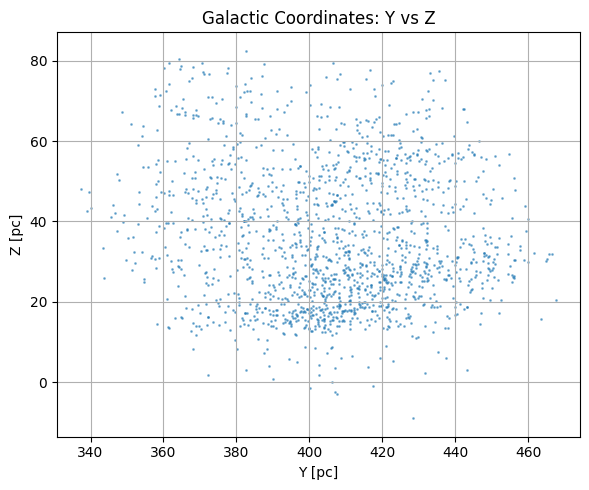

In [10]:
# Part 3

x_89,y_89,z_89 = gal_xyz(ra_89,dec_89,d_89,radec=True,plx=False,reverse=False)

# X vs Y
plt.figure(figsize=(6, 5))
plt.scatter(x_89, y_89, s=1, alpha=0.5)
plt.xlabel("X [pc]")
plt.ylabel("Y [pc]")
plt.title("Galactic Coordinates: X vs Y")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_xy.pdf") 
plt.show()

# X vs Z
plt.figure(figsize=(6, 5))
plt.scatter(x_89, z_89, s=1, alpha=0.5)
plt.xlabel("X [pc]")
plt.ylabel("Z [pc]")
plt.title("Galactic Coordinates: X vs Z")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_xz.pdf") 
plt.show()

# Y vs Z
plt.figure(figsize=(6, 5))
plt.scatter(y_89, z_89, s=1, alpha=0.5)
plt.xlabel("Y [pc]")
plt.ylabel("Z [pc]")
plt.title("Galactic Coordinates: Y vs Z")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_yz.pdf") 
plt.show()

In [11]:
# Part 4
pml_89, pmb_89 = pmgal(ra_89, dec_89, pmra_89, pmdec_89) 

vtl_89, vtb_89 = Vt(pml_89, pmb_89, d_89)

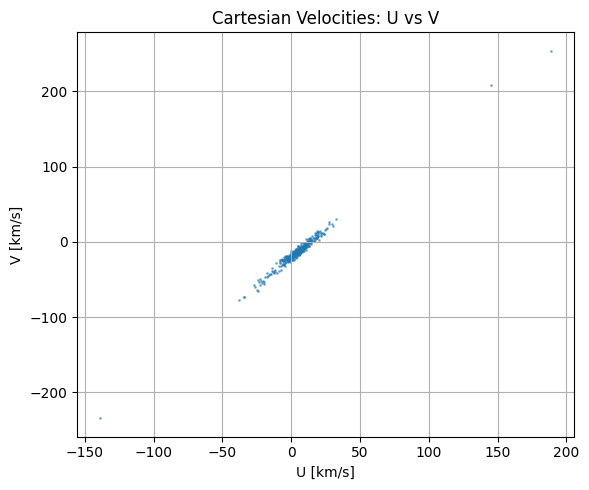

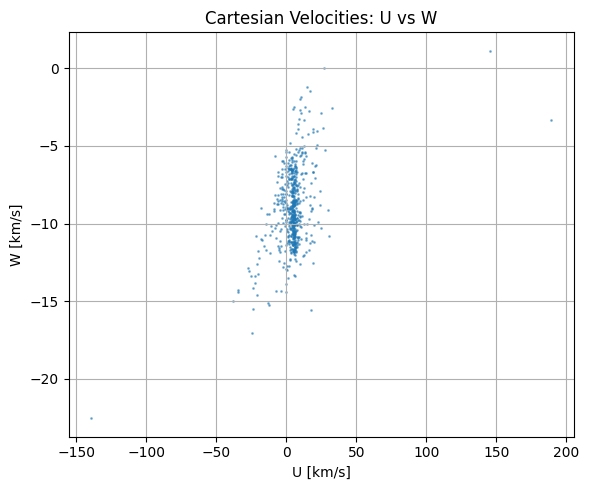

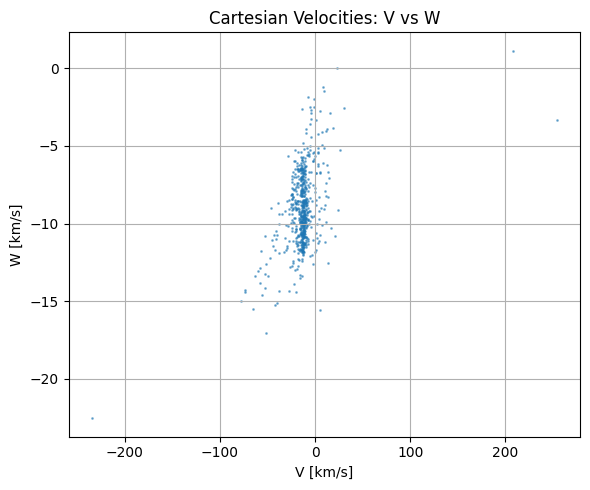

Average value of U: 4.458 km/s
Average value of V: -13.37 km/s
Average value of W: -9.016 km/s


In [12]:
# Part 5
u_vel_89, v_vel_89, w_vel_89 = gal_uvw(distance=d_89, lsr=None, ra=ra_89, dec=dec_89, pmra=pmra_89, pmdec=pmdec_89, vrad=rv_89, plx=None)

# U vs V
plt.figure(figsize=(6, 5))
plt.scatter(u_vel_89, v_vel_89, s=1, alpha=0.5)
plt.xlabel("U [km/s]")
plt.ylabel("V [km/s]")
plt.title("Cartesian Velocities: U vs V")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_uv.pdf") 
plt.show()

# U vs W
plt.figure(figsize=(6, 5))
plt.scatter(u_vel_89, w_vel_89, s=1, alpha=0.5)
plt.xlabel("U [km/s]")
plt.ylabel("W [km/s]")
plt.title("Cartesian Velocities: U vs W")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_uw.pdf") 
plt.show()

# V vs W
plt.figure(figsize=(6, 5))
plt.scatter(v_vel_89, w_vel_89, s=1, alpha=0.5)
plt.xlabel("V [km/s]")
plt.ylabel("W [km/s]")
plt.title("Cartesian Velocities: V vs W")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_vw.pdf") 
plt.show()

# Average Values
avg_u_89 = np.round(np.nanmean(u_vel_89), 3)
print(f"Average value of U: {avg_u_89} km/s")

avg_v_89 = np.round(np.nanmean(v_vel_89), 3)
print(f"Average value of V: {avg_v_89} km/s")

avg_w_89 = np.round(np.nanmean(w_vel_89), 3)
print(f"Average value of W: {avg_w_89} km/s")

In [13]:
# Part 6

u_arr_89 = np.full_like(ra_89, avg_u_89)
v_arr_89 = np.full_like(ra_89, avg_v_89)
w_arr_89 = np.full_like(ra_89, avg_w_89)

vrad_89, propra_89, propdec_89 = propmot(ra_89, dec_89, d_89, u_arr_89, v_arr_89, w_arr_89)

pml_proj_89, pmb_proj_89 = pmgal(ra_89, dec_89, propra_89, propdec_89) 

vtl_proj_89, vtb_proj_89 = Vt(pml_proj_89, pmb_proj_89, d_89)

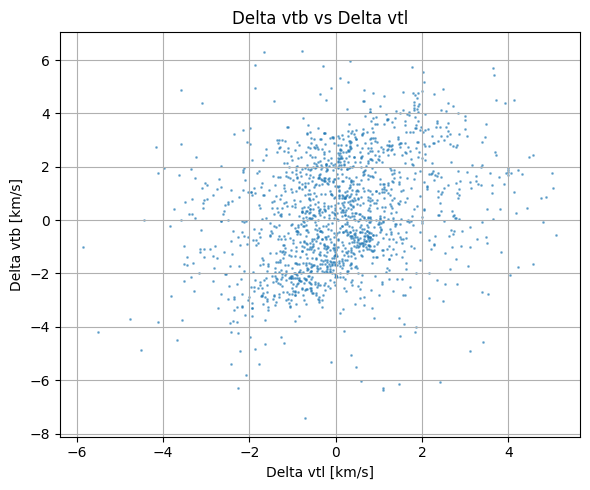

In [14]:
# Part 7

delta_vtl_89 = vtl_89 - vtl_proj_89
delta_vtb_89 = vtb_89 - vtb_proj_89

plt.figure(figsize=(6, 5))
plt.scatter(delta_vtl_89, delta_vtb_89, s=1, alpha=0.5)
plt.xlabel("Delta vtl [km/s]")
plt.ylabel("Delta vtb [km/s]")
plt.title("Delta vtb vs Delta vtl")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_anom.pdf") 
plt.show()

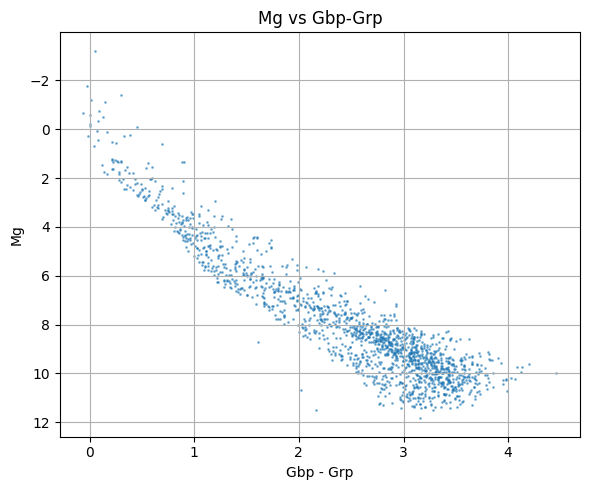

In [15]:
# Part 9

app_g_89 = df_pmem_scya89["g"].values
bp_89 = df_pmem_scya89["bp"].values
rp_89 = df_pmem_scya89["rp"].values
d_89_pmem = df_pmem_scya89["d"].values

abs_G_89 = app_g_89 - 5 * np.log10(d_89_pmem / 10)
bp_rp_89 = bp_89 - rp_89

plt.figure(figsize=(6, 5))
plt.scatter(bp_rp_89, abs_G_89, s=1, alpha=0.5)
plt.gca().invert_yaxis()  
plt.xlabel("Gbp - Grp")
plt.ylabel("Mg")
plt.title("Mg vs Gbp-Grp")
plt.grid()
plt.tight_layout()
plt.savefig("fig_scya_cmd.pdf") 
plt.show()

In [16]:
# Part 10

import hdbscan

In [17]:
# Part 11

velocity_scale = 8
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=7, cluster_selection_method='leaf')

columns_to_add = {
    "x_89": x_89,
    "y_89": y_89,
    "z_89": z_89,
    "d_89": d_89,
    "l_vals_89": l_vals_89,
    "b_vals_89": b_vals_89,
    "pml_89": pml_89,
    "pmb_89": pmb_89,
    "vtl_89": vtl_89,
    "vtb_89": vtb_89,
    "vtl_proj_89": vtl_proj_89,
    "vtb_proj_89": vtb_proj_89,
    "pmra_89": pmra_89,
    "pmdec_89": pmdec_89,
    "u_vel_89": u_vel_89,
    "v_vel_89": v_vel_89,
    "w_vel_89": w_vel_89,
}

for col, arr in columns_to_add.items():
    df_pmem_scya89[col] = arr

####################################################################################################################################

# Method A
X_scaled = df_pmem_scya89["x_89"]
Y_scaled = df_pmem_scya89["y_89"]
Z_scaled = df_pmem_scya89["z_89"]
Vtl_scaled = df_pmem_scya89["vtl_89"] * velocity_scale
Vtb_scaled = df_pmem_scya89["vtb_89"] * velocity_scale

# X_scaled = x_89
# Y_scaled = y_89
# Z_scaled = z_89
# Vtl_scaled = vtl_89 * velocity_scale
# Vtb_scaled = vtb_89 * velocity_scale

coords_a = np.vstack([
    X_scaled,
    Y_scaled,
    Z_scaled,
    Vtl_scaled,
    Vtb_scaled
]).T

labels_a = clusterer.fit_predict(coords_a)
df_pmem_scya89['cluster_a'] = labels_a  

####################################################################################################################################

# Method B


avg_d_89 = np.mean(df_pmem_scya89["d_89"])
l_proj_89 = df_pmem_scya89["l_vals_89"] * (np.pi / 180) * avg_d_89  # in parsecs
b_proj_89 = df_pmem_scya89["b_vals_89"]  * (np.pi / 180) * avg_d_89

coords_b = np.vstack([
    l_proj_89,
    b_proj_89,
    df_pmem_scya89["d_89"],
    Vtl_scaled,
    Vtb_scaled
]).T

labels_b = clusterer.fit_predict(coords_b)
df_pmem_scya89["cluster_b"] = labels_b

####################################################################################################################################

# Method C

coords_c = np.vstack([
    l_proj_89,
    b_proj_89,
    df_pmem_scya89["d_89"],
    df_pmem_scya89["pml_89"],
    df_pmem_scya89["pml_89"],
]).T

labels_c = clusterer.fit_predict(coords_c)
df_pmem_scya89["cluster_c"] = labels_c

####################################################################################################################################

# Method D

vtl_avgd, vtb_avgd = Vt(df_pmem_scya89["pml_89"].values, df_pmem_scya89["pmb_89"].values, avg_d_89)
vtl_anom = vtl_avgd - df_pmem_scya89["vtl_proj_89"]
vtb_anom = vtb_avgd - df_pmem_scya89["vtb_proj_89"]

coords_d = np.vstack([
    l_proj_89,
    b_proj_89,
    df_pmem_scya89["d_89"],
    vtl_anom * velocity_scale,
    vtb_anom * velocity_scale
]).T

labels_d = clusterer.fit_predict(coords_d)
df_pmem_scya89["cluster_d"] = labels_d




/home/mayesha/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mayesha/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mayesha/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mayesha/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mayesha/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

cluster_d


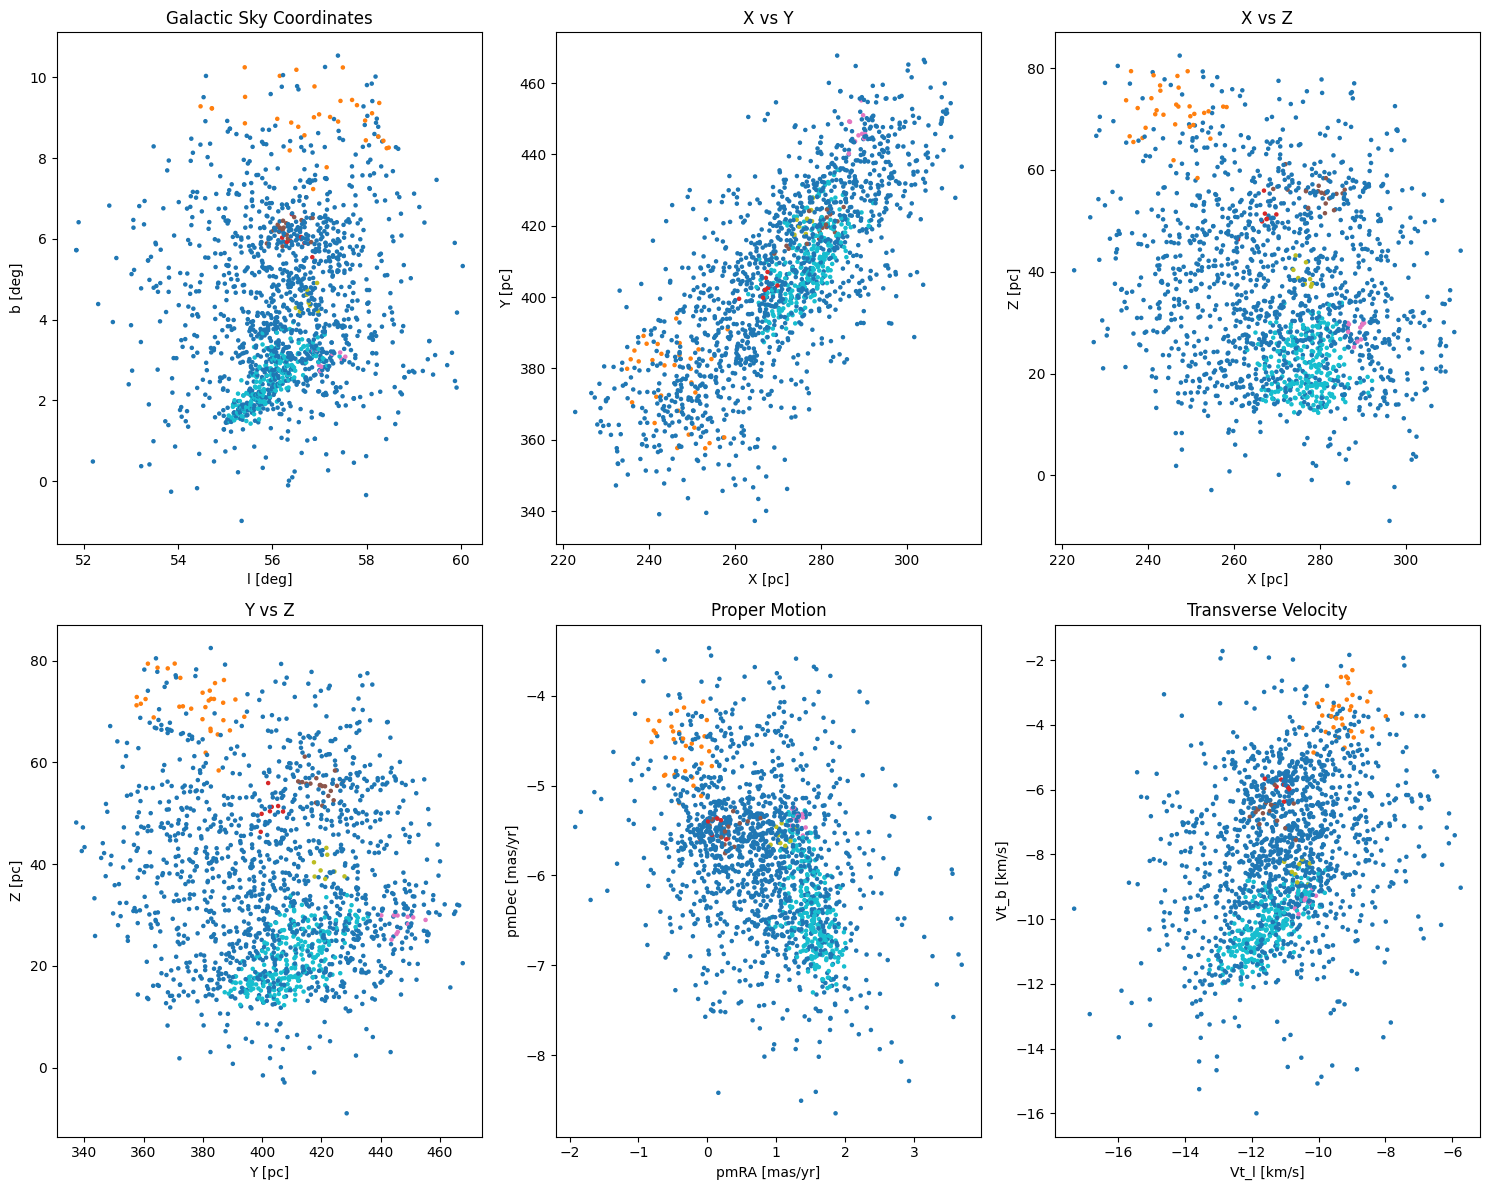

In [18]:
# Part 12 
cluster = 'cluster_d'

print(cluster)

fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.flatten()  

# 1. Sky coordinates (l, b)
axes[0].scatter(df_pmem_scya89["l_vals_89"].values, df_pmem_scya89["b_vals_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[0].set_xlabel('l [deg]')
axes[0].set_ylabel('b [deg]')
axes[0].set_title('Galactic Sky Coordinates')

# 2. Spatial (X, Y)
axes[1].scatter(df_pmem_scya89["x_89"].values, df_pmem_scya89["y_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[1].set_xlabel('X [pc]')
axes[1].set_ylabel('Y [pc]')
axes[1].set_title('X vs Y')

# 3. Spatial (X, Z)
axes[2].scatter(df_pmem_scya89["x_89"].values, df_pmem_scya89["z_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[2].set_xlabel('X [pc]')
axes[2].set_ylabel('Z [pc]')
axes[2].set_title('X vs Z')

# 4. Spatial (Y, Z)
axes[3].scatter(df_pmem_scya89["y_89"].values, df_pmem_scya89["z_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[3].set_xlabel('Y [pc]')
axes[3].set_ylabel('Z [pc]')
axes[3].set_title('Y vs Z')

# 5. Proper motion space
axes[4].scatter(df_pmem_scya89["pmra_89"].values, df_pmem_scya89["pmdec_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[4].set_xlabel('pmRA [mas/yr]')
axes[4].set_ylabel('pmDec [mas/yr]')
axes[4].set_title('Proper Motion')

# 6. Transverse velocity
axes[5].scatter(df_pmem_scya89["vtl_89"].values, df_pmem_scya89["vtb_89"].values, c=df_pmem_scya89[cluster], s=5, cmap='tab10')
axes[5].set_xlabel('Vt_l [km/s]')
axes[5].set_ylabel('Vt_b [km/s]')
axes[5].set_title('Transverse Velocity')

plt.tight_layout()
plt.savefig("fig_scya_clusters.pdf") 
plt.show()